## Import libraries

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

from shapely import wkt

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Config notebook

In [26]:
#Insert CVEGEOs of interest 
#'08051' for Ocampo - Basaseachi
cvegeo_list = ['08051']

#Save to Data Base?
savetodb = True

## Download data

Download municipalities

<Axes: >

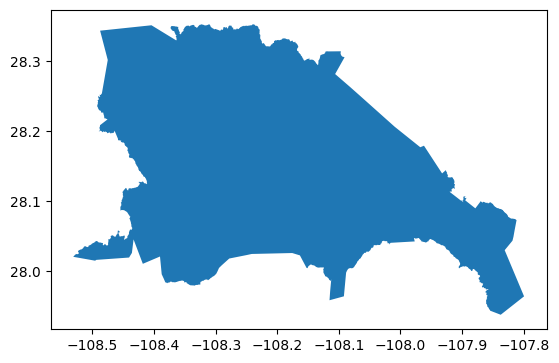

In [4]:
#Query municipalities
mun_schema = 'marco'
mun_table = 'mpos_2020'

mun_gdf = gpd.GeoDataFrame()
# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {mun_schema}.{mun_table} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    mun_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    mun_gdf = pd.concat([mun_gdf, mun_tmp],
    ignore_index = True, axis = 0)

#Define projections and plot
mun_gdf = mun_gdf.set_crs("EPSG:4326")
mun_gdf.plot()

## Process

Generate bounding box to download osmnx

In [5]:
# Read mun_gdf GeoDataFrame as polygon
poly = mun_gdf.geometry
# Extract coordinates from polygon as DataFrame
coord_val = poly.bounds

In [6]:
# Get coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

print(n,s,e,w)

28.353341680464634 27.9374576201659 -107.79944047955378 -108.53135251997088


Download OSMnx graph from bounding box and create gdf

In [7]:
# Download OSMnx graph
G = ox.graph_from_bbox(n, s, e, w, network_type="all")

In [8]:
# Transforms graph to nodes and edges GeoDataFrame
nodes, edges = ox.graph_to_gdfs(G)

Format for upload to database

In [9]:
# Resets index to access osmid as column
nodes.reset_index(inplace=True)

# Resets index to access u and v as columns
edges.reset_index(inplace=True)

In [10]:
# Defines columns for nodes and edges for upload to database
nodes_columns = ["osmid", "x", "y", "street_count", "geometry"]
edges_columns = [
            "osmid",
            "v",
            "u",
            "key",
            "oneway",
            "lanes",
            "name",
            "highway",
            "maxspeed",
            "length",
            "geometry",
            "bridge",
            "ref",
            "junction",
            "tunnel",
            "access",
            "width",
            "service"]

# if column doesn't exist it creates it as nan
for e in nodes_columns:
    if e not in nodes.columns:
        nodes[e] = np.nan

for e in edges_columns:
    if e not in edges.columns:
        edges[e] = np.nan

In [11]:
# Filters GeoDataFrames for relevant columns    
nodes = nodes[nodes_columns]
edges = edges[edges_columns]

### Solve problems with geometry:

In [32]:
edges['geometry'] = edges['geometry'].apply(lambda x: x.__str__())
edges['geometry'] = edges['geometry'].apply(wkt.loads)

<Axes: >

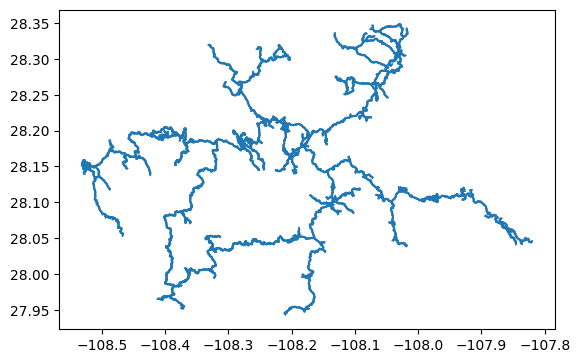

In [33]:
edges = edges.set_crs("EPSG:4326")
edges.plot()

In [30]:
nodes['geometry'] = nodes['geometry'].apply(lambda x: x.__str__())
nodes['geometry'] = nodes['geometry'].apply(wkt.loads)

/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1442: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


<Axes: >

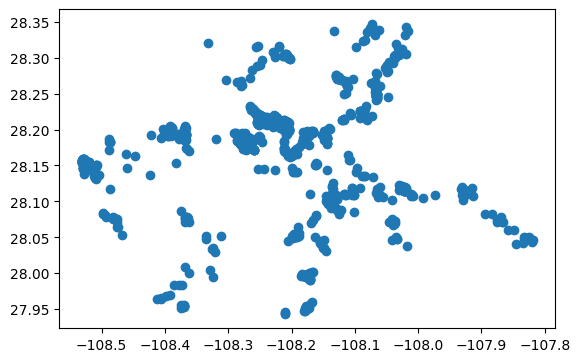

In [31]:
nodes = nodes.set_crs("EPSG:4326")
nodes.plot()

## Save to db

In [34]:
if savetodb:
    aup.gdf_to_db_slow(nodes, "nodes_basaseachi", schema="osmnx", if_exists="append")
    aup.gdf_to_db_slow(edges, "edges_basaseachi", schema="osmnx", if_exists="append")

# Find trouble

In [24]:
print(nodes.shape)
nodes.head(2)

(1229, 5)


,osmid,x,y,street_count,geometry
0,2277868897,-108.524005,28.150811,3,POINT (-108.52401 28.15081)
1,2277868940,-108.525829,28.153679,3,POINT (-108.52583 28.15368)


In [25]:
print(edges.shape)
edges.head(2)

(2848, 18)


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service
0,771518489,7241559248,2277868897,0,False,NaN,NaN,residential,NaN,70.693,"LINESTRING (-108.52401 28.15081, -108.52328 28...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,220755635,7484072461,2277868897,0,False,NaN,Avenida Aeropuerto,tertiary,NaN,101.784,"LINESTRING (-108.52401 28.15081, -108.52397 28...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
